# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter =';')
azdias.shape

(891221, 85)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
pd.concat([azdias.head(3), azdias.sample(6), azdias.tail(3)])


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
173641,-1,2,2,4.0,3,4,2,5,4,1,...,4.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,4.0,1.0
176089,-1,1,2,6.0,1,4,3,5,5,2,...,3.0,1.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
67500,2,4,2,1.0,3,1,5,1,1,5,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,9.0,3.0
353743,-1,3,2,6.0,1,4,3,5,3,5,...,2.0,3.0,1.0,0.0,1.0,4.0,4.0,1.0,3.0,1.0
398597,3,2,1,6.0,3,1,4,2,1,5,...,2.0,3.0,2.0,0.0,1.0,3.0,3.0,4.0,4.0,3.0
270222,-1,2,1,1.0,3,3,3,3,1,3,...,2.0,3.0,1.0,0.0,1.0,3.0,4.0,4.0,1.0,3.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0


In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=';')

In [5]:
pd.concat([feat_info.head(3), feat_info.tail(3)])

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
13,GREEN_AVANTGARDE,person,categorical,[]
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
38,SHOPPER_TYP,person,categorical,[-1]
11,GEBURTSJAHR,person,numeric,[0]
42,ZABEOTYP,person,categorical,"[-1,9]"
82,ARBEIT,community,ordinal,"[-1,9]"


In [6]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [7]:
feat_info[feat_info.missing_or_unknown.isin(["[XX]","[-1,XX]"])]

,attribute,information_level,type,missing_or_unknown
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [8]:
feat_info.information_level.value_counts()

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
microcell_rr4      3
postcode           3
community          3
Name: information_level, dtype: int64

In [9]:
feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [11]:
# keep the source untouched - use a copy for cleaning
azdias_clean = azdias.copy()

In [12]:
def replace_by_nan(x, *valuelist_to_replace):
    """ if the string converted value is in the list it will replace it with nan
    """
    return np.nan if str(x) in valuelist_to_replace else x

def replace_nan_in_df(df, feat_info):

    for col in df.columns:
        m_or_u = feat_info[feat_info.attribute==col]["missing_or_unknown"].item()
        m_or_u_list = m_or_u.strip('[]').strip()
        if len(m_or_u_list)==0:
            continue
        m_or_u_values = m_or_u_list.split(',')
        m_or_u_values = list(x.strip() for x in m_or_u_values)
        print(f"For attribute {col} replace {m_or_u_values} with NaN")
        df[col] = df[col].apply(replace_by_nan, args=m_or_u_values)
    return df

azdias_clean = replace_nan_in_df(azdias_clean, feat_info)

For attribute AGER_TYP replace ['-1', '0'] with NaN
For attribute ALTERSKATEGORIE_GROB replace ['-1', '0', '9'] with NaN
For attribute ANREDE_KZ replace ['-1', '0'] with NaN
For attribute CJT_GESAMTTYP replace ['0'] with NaN
For attribute FINANZ_MINIMALIST replace ['-1'] with NaN
For attribute FINANZ_SPARER replace ['-1'] with NaN
For attribute FINANZ_VORSORGER replace ['-1'] with NaN
For attribute FINANZ_ANLEGER replace ['-1'] with NaN
For attribute FINANZ_UNAUFFAELLIGER replace ['-1'] with NaN
For attribute FINANZ_HAUSBAUER replace ['-1'] with NaN
For attribute FINANZTYP replace ['-1'] with NaN
For attribute GEBURTSJAHR replace ['0'] with NaN
For attribute HEALTH_TYP replace ['-1', '0'] with NaN
For attribute LP_LEBENSPHASE_FEIN replace ['0'] with NaN
For attribute LP_LEBENSPHASE_GROB replace ['0'] with NaN
For attribute LP_FAMILIE_FEIN replace ['0'] with NaN
For attribute LP_FAMILIE_GROB replace ['0'] with NaN
For attribute LP_STATUS_FEIN replace ['0'] with NaN
For attribute LP_STAT

In [13]:
def get_df_nans(df_original, df_clean):
    
    df_nans = df_original.isna().sum().reset_index()
    df_nans.columns=["attr","nan_before"]
    
    df_nans_post=df_clean.isna().sum().reset_index()
    df_nans_post.columns=["attr","nan_actual"]
    
    if "nan_actual" in df_nans.columns:
        df_nans.drop(["nan_actual"], inplace=True, axis=1)
    df_nans = pd.merge(left=df_nans, right=df_nans_post, left_on="attr", right_on="attr")
    
    df_nans["valid_entries"]=df_clean.shape[0] - df_nans["nan_actual"]
    df_nans["perc_valid"]=100 * (df_clean.shape[0] - df_nans["nan_actual"]) / df_clean.shape[0]
    
    if "type" in df_nans.columns:
        df_nans.drop(["type","information_level"], inplace=True, axis=1)
    df_nans = pd.merge(left=df_nans, right=feat_info[["attribute", "type","information_level"]], left_on="attr", right_on="attribute")
    df_nans.drop(["attribute"], inplace=True, axis=1)
    
    df_nans["val_cnt"] = df_nans["attr"].apply(lambda x: len(azdias_clean[x].value_counts()))
    return df_nans

df_nans = get_df_nans(azdias, azdias_clean)

In [14]:
df_with_nans = df_nans[df_nans["nan_actual"]>0]
df_with_nans.sort_values("nan_actual", ascending=False)

,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt
0,AGER_TYP,0,685843,205378,23.044565,categorical,person,3
47,KK_KUNDENTYP,584612,584612,306609,34.403251,categorical,household,6
11,GEBURTSJAHR,0,392318,498903,55.979718,numeric,person,116
63,KBA05_ANTG4,133324,133324,757897,85.040299,ordinal,microcell_rr3,3
60,KBA05_ANTG1,133324,133324,757897,85.040299,ordinal,microcell_rr3,5
...,...,...,...,...,...,...,...,...
16,LP_LEBENSPHASE_GROB,4854,4854,886367,99.455354,mixed,person,13
15,LP_LEBENSPHASE_FEIN,4854,4854,886367,99.455354,mixed,person,41
12,GFK_URLAUBERTYP,4854,4854,886367,99.455354,categorical,person,12
3,CJT_GESAMTTYP,4854,4854,886367,99.455354,categorical,person,6


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

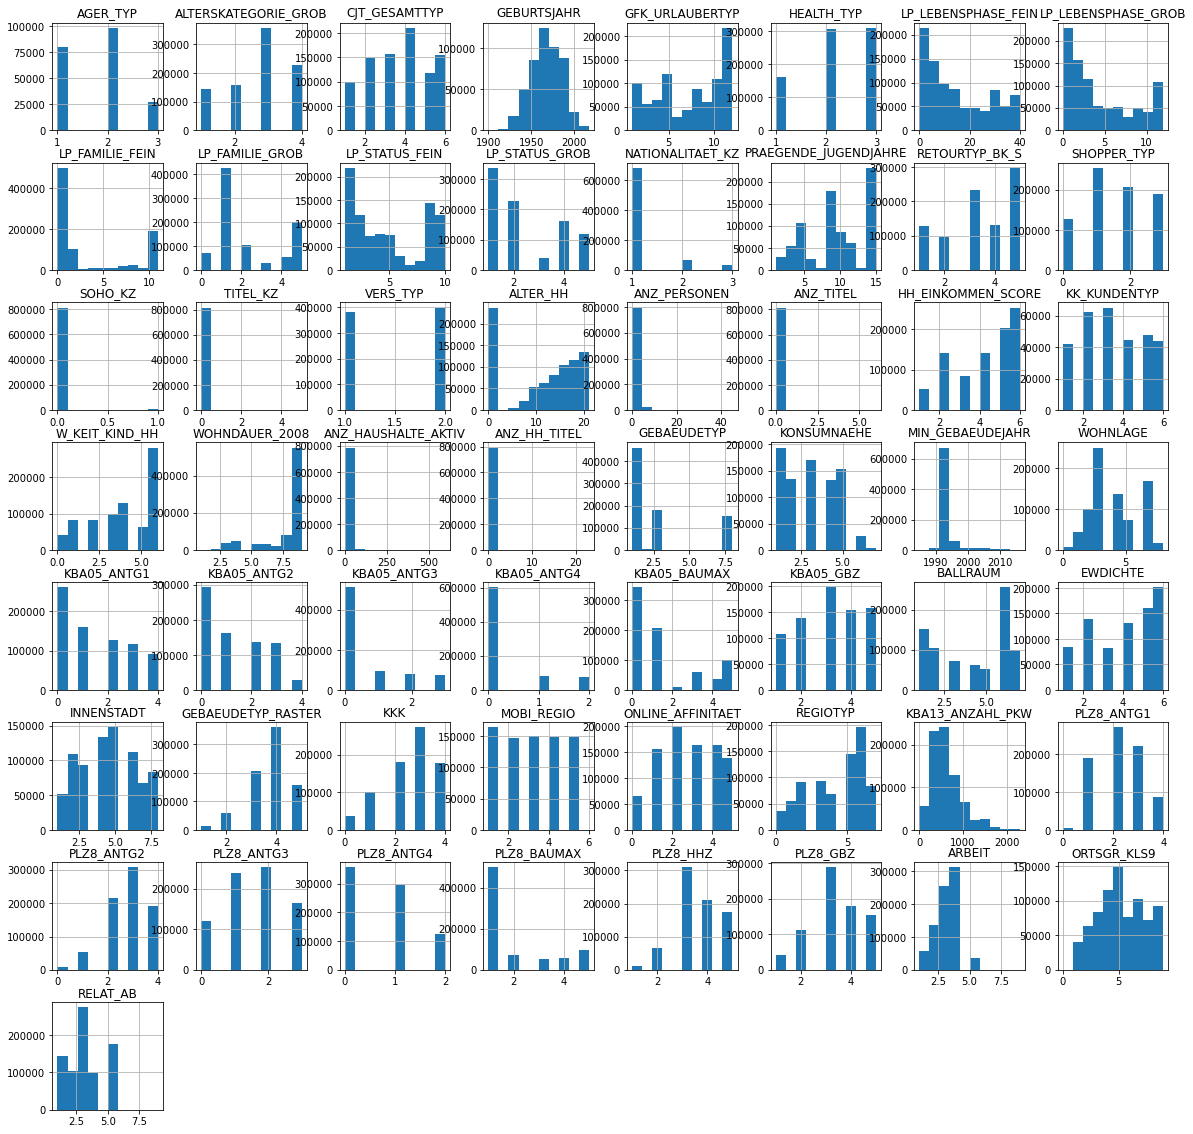

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_clean[df_with_nans["attr"].tolist()].hist(figsize=(20,20));

In [16]:
def get_delete_candidates(df, attributes, ignore_list):
    delete_candidate_list=[]
    for col in attributes: 
        if col in ignore_list:
            # mixed value will be handled later
            continue
        nan_cnt=df[col].isna().sum()
        val_count_list = df[col].value_counts().tolist()    
        delete_reason=""
        if len(val_count_list)>1:
            if nan_cnt >= val_count_list[0]:
                delete_reason=f"More Nan than 1st\n{nan_cnt}>={val_count_list[0]}"
                delete_candidate_list.append((col,delete_reason))
            elif nan_cnt >= val_count_list[1]:            
                delete_reason=f"More Nan than 2nd\n{nan_cnt}>={val_count_list[1]}"
                delete_candidate_list.append((col,delete_reason))
        else:
            # only one entry, no new information
            delete_reason="Single Value"
            delete_candidate_list.append((col,delete_reason))
    
    return delete_candidate_list

attributes = df_with_nans["attr"].tolist()
ignore_list = ["CAMEO_INTL_2015"]
delete_candidate_list = get_delete_candidates(azdias_clean, attributes, ignore_list)


In [17]:
# update the nan log dataframe

# first create new dataframe with attributes to delete
df_deleted = pd.DataFrame(delete_candidate_list)
df_deleted.columns=["attribute","del_reason"]
df_deleted["del_reason"]=df_deleted["del_reason"].apply(lambda x: x.split("\n")[0])
df_deleted["del_col"]=1

# then merge it into the nans log dataframe
if "del_reason" in df_nans.columns:
    df_nans.drop(["del_reason","del_col"], inplace=True, axis=1)
df_nans = pd.merge(left=df_nans, right=df_deleted, how="left", left_on="attr", right_on="attribute")
df_nans.drop(["attribute"], inplace=True, axis=1)
df_nans["del_col"] = df_nans["del_col"].fillna(0)
df_nans.head(10)


,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col
0,AGER_TYP,0,685843,205378,23.044565,categorical,person,3,More Nan than 1st,1.0
1,ALTERSKATEGORIE_GROB,0,2881,888340,99.676736,ordinal,person,4,NaN,0.0
2,ANREDE_KZ,0,0,891221,100.000000,categorical,person,2,NaN,0.0
3,CJT_GESAMTTYP,4854,4854,886367,99.455354,categorical,person,6,NaN,0.0
4,FINANZ_MINIMALIST,0,0,891221,100.000000,ordinal,person,5,NaN,0.0
5,FINANZ_SPARER,0,0,891221,100.000000,ordinal,person,5,NaN,0.0
6,FINANZ_VORSORGER,0,0,891221,100.000000,ordinal,person,5,NaN,0.0
7,FINANZ_ANLEGER,0,0,891221,100.000000,ordinal,person,5,NaN,0.0
8,FINANZ_UNAUFFAELLIGER,0,0,891221,100.000000,ordinal,person,5,NaN,0.0
9,FINANZ_HAUSBAUER,0,0,891221,100.000000,ordinal,person,5,NaN,0.0


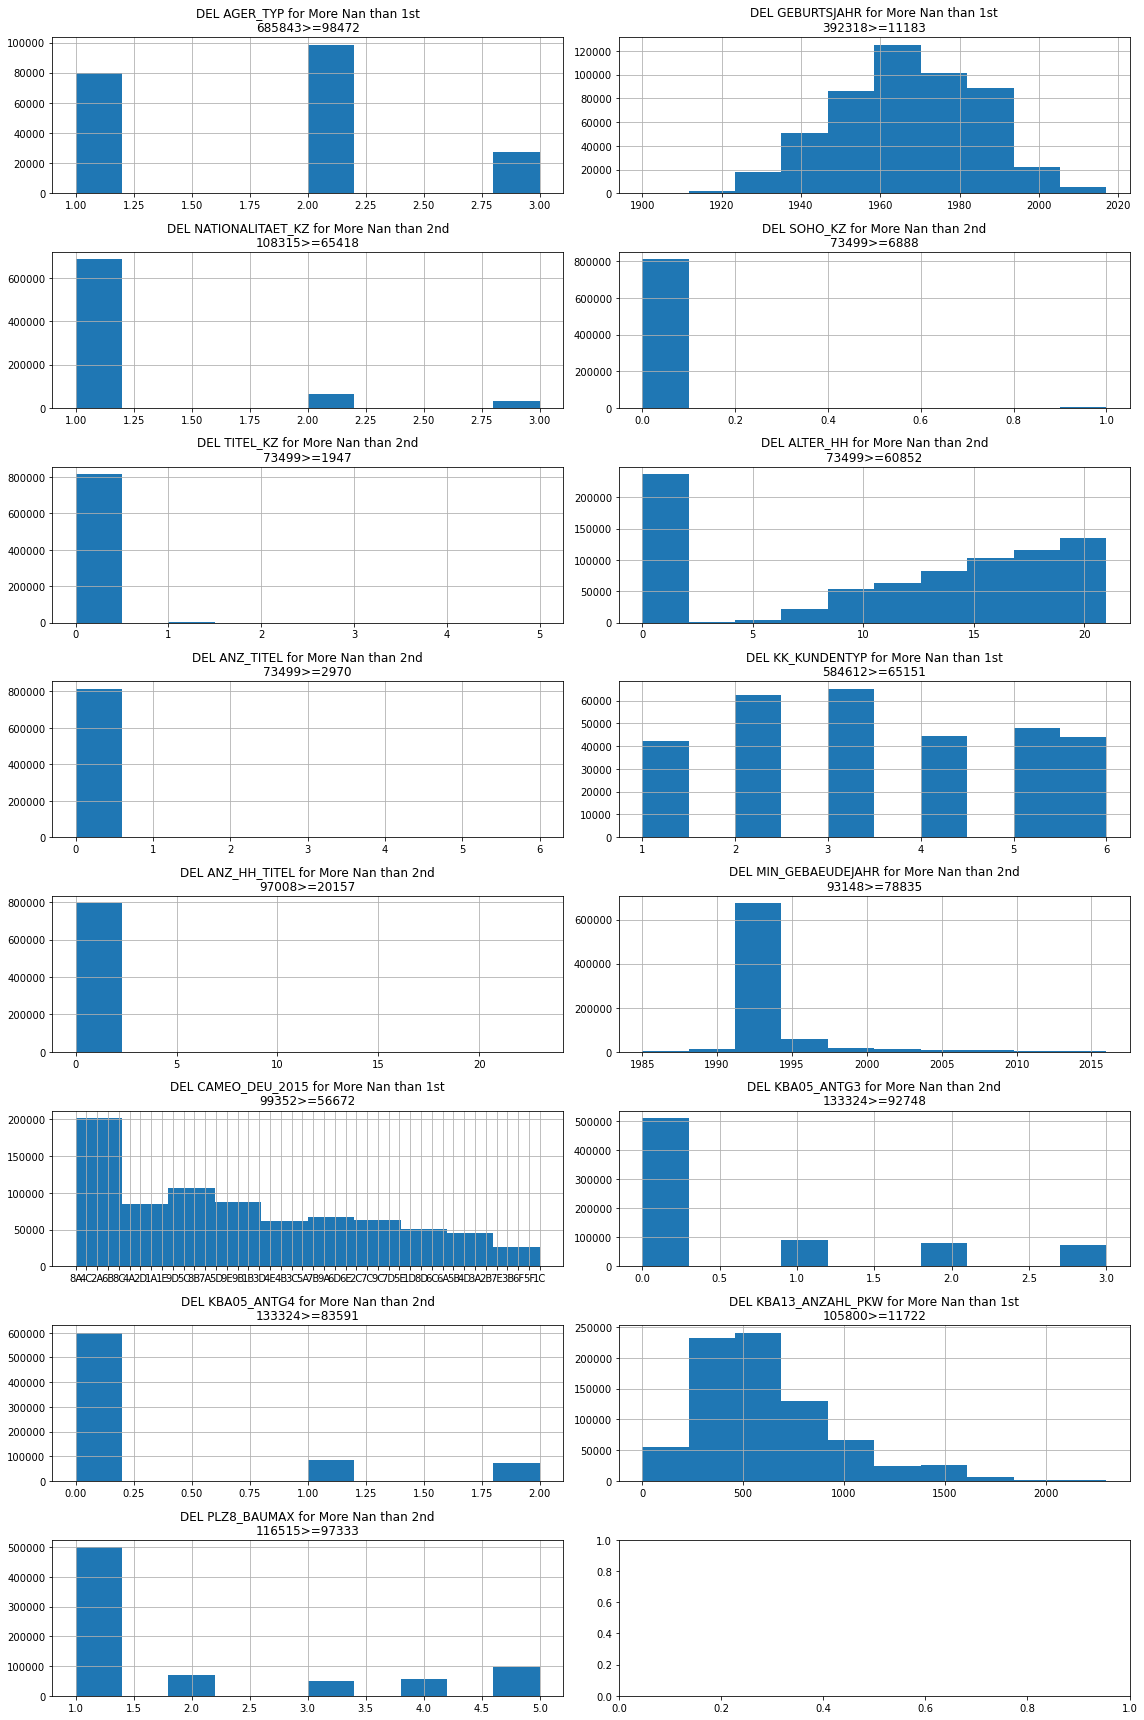

In [18]:
# print historam for all delete candidates
nrows=int(len(delete_candidate_list)/2)+1
ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(16,min(24,nrows*4)))
ax_cnt=0
for col,reason in delete_candidate_list:            
    ax_row = int(ax_cnt/2)
    ax_col = ax_cnt%2
    azdias_clean[col].hist(ax=ax[ax_row][ax_col])  
    ax[ax_row][ax_col].set_title(f"DEL {col} for {reason}")
    ax_cnt += 1 
fig.tight_layout()

In [19]:
# Investigate patterns in the amount of missing data in each column.
df_same_nan_group = df_nans.groupby("valid_entries").count().reset_index()
df_same_nan_group

,valid_entries,attr,nan_before,nan_actual,perc_valid,type,information_level,val_cnt,del_reason,del_col
0,205378,1,1,1,1,1,1,1,1,1
1,306609,1,1,1,1,1,1,1,1,1
2,498903,1,1,1,1,1,1,1,1,1
3,757897,7,7,7,7,7,7,7,2,7
4,770025,2,2,2,2,2,2,2,0,2
5,774706,7,7,7,7,7,7,7,1,7
6,780025,3,3,3,3,3,3,3,0,3
7,782906,1,1,1,1,1,1,1,1,1
8,783057,1,1,1,1,1,1,1,0,1
9,783619,1,1,1,1,1,1,1,0,1


In [20]:
# focus on the rough and fine data
df_nans[df_nans["attr"].str.contains("_FEIN") | df_nans["attr"].str.contains("_GROB")]

,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col
1,ALTERSKATEGORIE_GROB,0,2881,888340,99.676736,ordinal,person,4,NaN,0.0
15,LP_LEBENSPHASE_FEIN,4854,4854,886367,99.455354,mixed,person,41,NaN,0.0
16,LP_LEBENSPHASE_GROB,4854,4854,886367,99.455354,mixed,person,13,NaN,0.0
17,LP_FAMILIE_FEIN,4854,4854,886367,99.455354,categorical,person,12,NaN,0.0
18,LP_FAMILIE_GROB,4854,4854,886367,99.455354,categorical,person,6,NaN,0.0
19,LP_STATUS_FEIN,4854,4854,886367,99.455354,categorical,person,10,NaN,0.0
20,LP_STATUS_GROB,4854,4854,886367,99.455354,categorical,person,5,NaN,0.0


In [21]:
df_rough_fine = azdias_clean[["LP_LEBENSPHASE_FEIN","LP_LEBENSPHASE_GROB", "LP_FAMILIE_FEIN","LP_FAMILIE_GROB", "LP_STATUS_FEIN","LP_STATUS_GROB"]].copy()
df_rough_fine["nan_cnt"] = df_rough_fine.isnull().sum(axis = 1)
df_rough_fine["nan_cnt"].value_counts()

0    886367
6      4854
Name: nan_cnt, dtype: int64

<span style="color:blue">
    
#### Student Note: Rough or fine grained information?

There is no need to decide regarding to the nan values. Either all are there or all 6 are missing. Maybe we should later pick one when it comes to creating dummies.
</span>

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def remove_all_delete_candidates(df, delete_candidate_list):
    attr_to_del = list(x[0] for x in delete_candidate_list)
    attr_to_del_verified=[]
    for attr in attr_to_del:
        if attr in df.columns:
            attr_to_del_verified.append(attr)
    df_cleaned = df.drop(columns=attr_to_del_verified, axis=1)
    return df_cleaned
        
azdias_cleaned_col = remove_all_delete_candidates(azdias_clean, delete_candidate_list)

#### Discussion 1.1.2: Assess Missing Data in Each Column

<span style="color:blue">
    
#### Student Note:
All columns where deleted where the number of missing entries was more than the first or second largest number of valid entries.
Some attributes like GEBURTSJAHR, AGER_TYP KK_KUNDENTYP had a very low number (55% and less) of valid entries and were obviously to remove.
</span>

<!--
(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
-->

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

df_nan_per_row = azdias_cleaned_col.isnull().sum(axis = 1).reset_index()
df_nan_per_row.columns=["row", "nans"]

In [24]:
df_nan_per_row.describe()

,row,nans
count,891221.000000,891221.000000
mean,445610.000000,4.135350
std,257273.486465,10.020432
min,0.000000,0.000000
25%,222805.000000,0.000000
50%,445610.000000,0.000000
75%,668415.000000,1.000000
max,891220.000000,41.000000


<AxesSubplot:>

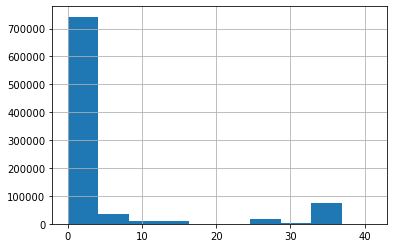

In [25]:
df_nan_per_row["nans"].hist()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
ALLOWED_MISSING_VALUES_PER_ROW = 1
azdias_clean_row = azdias_cleaned_col.copy()

def remove_rows_with_x_nan(df, allowed_nan_per_row):    
    df["nan_cnt"] = df.isnull().sum(axis = 1)
    azdias_clean_many_nan = df[azdias_clean_row["nan_cnt"] > allowed_nan_per_row]
    azdias_clean_few_nan = df[azdias_clean_row["nan_cnt"] <= allowed_nan_per_row]
    # and delete the nan cnt helper attriubte again    
    azdias_clean_many_nan = azdias_clean_many_nan.drop(columns=["nan_cnt"], axis=1)
    azdias_clean_few_nan = azdias_clean_few_nan.drop(columns=["nan_cnt"], axis=1)
    df = df.drop(columns=["nan_cnt"], axis=1)
    return azdias_clean_few_nan,azdias_clean_many_nan

azdias_clean_few_nan,azdias_clean_many_nan = remove_rows_with_x_nan(azdias_clean_row, ALLOWED_MISSING_VALUES_PER_ROW)
print(f"Few NaN Rows: {azdias_clean_few_nan.shape[0]}, Many NaN Rows: {azdias_clean_many_nan.shape[0]}")
print(f"Reduction: {100*(azdias_clean.shape[0] - azdias_clean_few_nan.shape[0])/azdias_clean.shape[0]}%")


Few NaN Rows: 694455, Many NaN Rows: 196766
Reduction: 22.078249951471072%


In [27]:
df_nans_post_rows=azdias_clean_few_nan.isna().sum().reset_index()
df_nans_post_rows.columns=["attr","actual_nan_rows"]
if "actual_nan_rows" in df_nans.columns:
    df_nans.drop(["actual_nan_rows"], inplace=True, axis=1)
df_nans = pd.merge(left=df_nans, right=df_nans_post_rows, how="left", left_on="attr", right_on="attr")
# store the data
df_nans.to_csv("nans_delete_table.csv")

df_nans[df_nans["actual_nan_rows"]>0].sort_values("actual_nan_rows", ascending=False)


,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col,actual_nan_rows
48,W_KEIT_KIND_HH,107602,107602,783619,87.926451,ordinal,household,7,NaN,0.0,28746.0
22,PRAEGENDE_JUGENDJAHRE,0,108164,783057,87.863392,mixed,person,15,NaN,0.0,6663.0
53,KONSUMNAEHE,73969,73969,817252,91.700263,ordinal,building,7,NaN,0.0,34.0


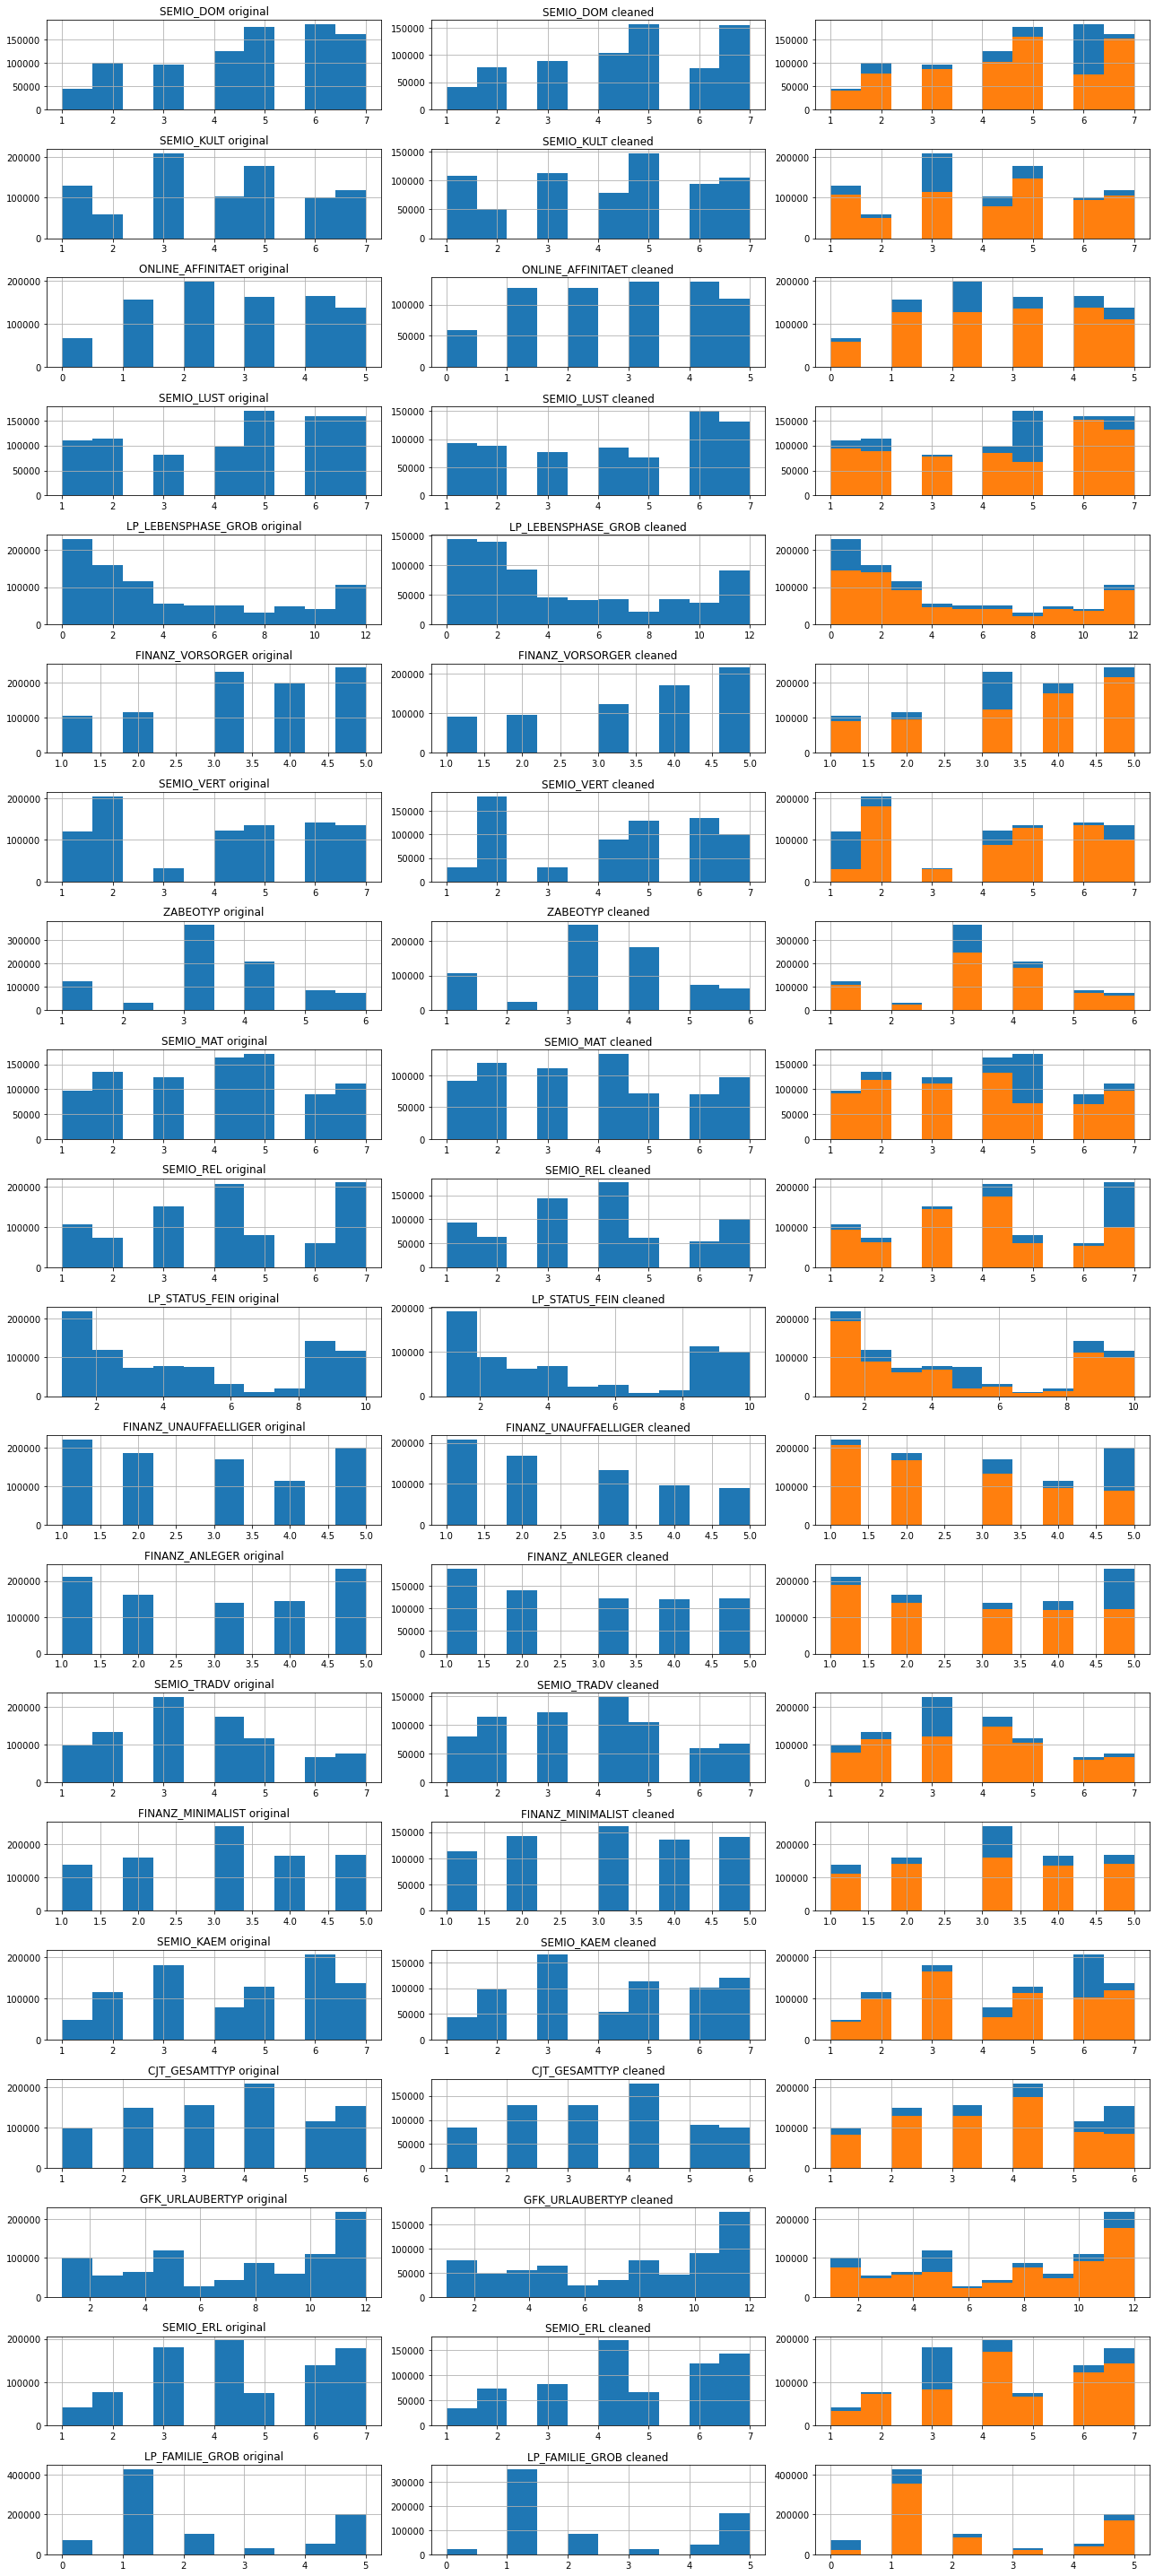

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

df_no_or_few_missing = df_nans[df_nans["perc_valid"]>99].sort_values("perc_valid", ascending=False).sample(20)

fig, ax = plt.subplots(ncols=3, nrows=20, figsize=(18,40))

row=0

for attr in df_no_or_few_missing["attr"]:
    azdias[attr].hist(ax=ax[row][0])
    ax[row][0].set_title(f"{attr} original")
    azdias_clean_few_nan[attr].hist(ax=ax[row][1])
    ax[row][1].set_title(f"{attr} cleaned")
    azdias[attr].hist(ax=ax[row][2])
    azdias_clean_few_nan[attr].hist(ax=ax[row][2])
    row += 1
fig.tight_layout()
    


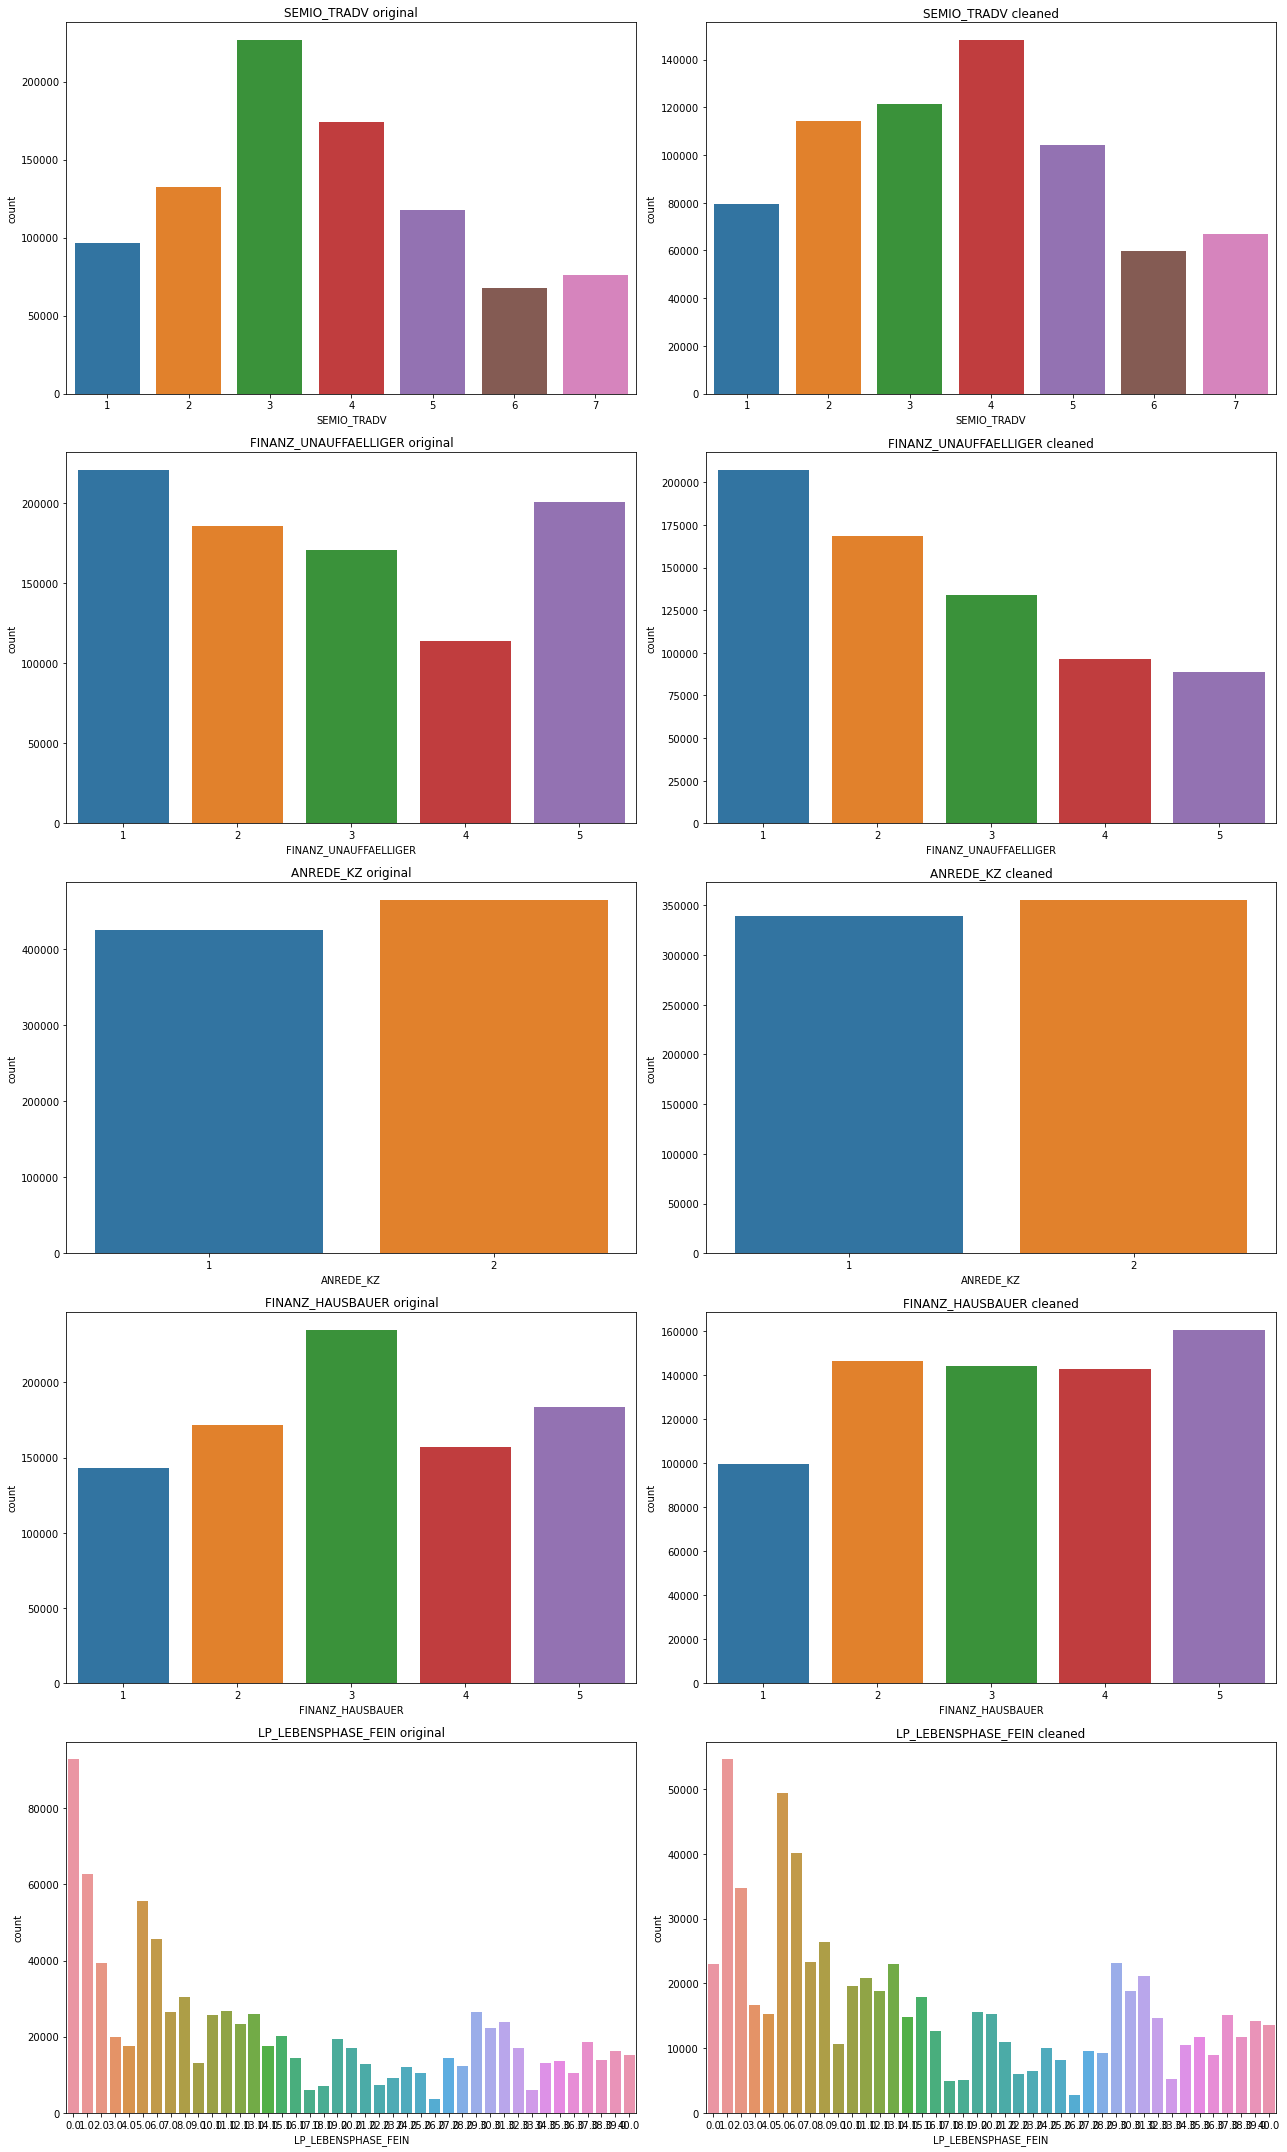

In [29]:

df_no_or_few_missing = df_nans[df_nans["perc_valid"]>99].sort_values("perc_valid", ascending=False).sample(5)

fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(18,30))

row=0

for attr in df_no_or_few_missing["attr"]:
    sns.countplot(x=azdias[attr],ax=ax[row][0]).set(title=f"{attr} original")    
    sns.countplot(x=azdias_clean_few_nan[attr],ax=ax[row][1]).set(title=f"{attr} cleaned")
    row += 1
fig.tight_layout()


#### Discussion 1.1.3: Assess Missing Data in Each Row

<span style="color:blue">
    
#### Student Note:
A very aggressive deleting was choosen by only allowing 1 nan per each row (and even that will be removed later on). This deletes about 20% from the datasets. The problem with deleting rows is, that the dataset of the valid entries may change its picture. By looking at the histograms we see that the changes are still tolerable. 
</span>

<!--
(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
-->

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?

feat_info[feat_info["attribute"].isin(azdias_clean_few_nan.columns)]["type"].value_counts()

ordinal        47
categorical    15
mixed           6
numeric         2
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
list_categorical_attr = feat_info[(feat_info["attribute"].isin(azdias_clean_few_nan.columns)) 
                                  & (feat_info["type"]=="categorical")].attribute.tolist()


In [32]:
azdias_clean_few_nan[list_categorical_attr].head(5)


,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,SHOPPER_TYP,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,3.0,2.0,5,8.0,W,8
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,2.0,1.0,5,1.0,W,4
3,2,2.0,6,1.0,0,0.0,0.0,9.0,4.0,1.0,1.0,3,1.0,W,2
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,2.0,2.0,4,1.0,W,6
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,0.0,2.0,4,1.0,W,8


In [33]:
df_nans_categorical = df_nans[df_nans["type"]=="categorical"]
df_nans_categorical

,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col,actual_nan_rows
0,AGER_TYP,0,685843,205378,23.044565,categorical,person,3,More Nan than 1st,1.0,NaN
2,ANREDE_KZ,0,0,891221,100.000000,categorical,person,2,NaN,0.0,0.0
3,CJT_GESAMTTYP,4854,4854,886367,99.455354,categorical,person,6,NaN,0.0,0.0
10,FINANZTYP,0,0,891221,100.000000,categorical,person,6,NaN,0.0,0.0
12,GFK_URLAUBERTYP,4854,4854,886367,99.455354,categorical,person,12,NaN,0.0,0.0
13,GREEN_AVANTGARDE,0,0,891221,100.000000,categorical,person,2,NaN,0.0,0.0
17,LP_FAMILIE_FEIN,4854,4854,886367,99.455354,categorical,person,12,NaN,0.0,0.0
18,LP_FAMILIE_GROB,4854,4854,886367,99.455354,categorical,person,6,NaN,0.0,0.0
19,LP_STATUS_FEIN,4854,4854,886367,99.455354,categorical,person,10,NaN,0.0,0.0
20,LP_STATUS_GROB,4854,4854,886367,99.455354,categorical,person,5,NaN,0.0,0.0


In [34]:
df_nans_categorical = df_nans_categorical[df_nans_categorical["del_col"]==0]
df_nans_categorical_to_encode = df_nans_categorical[df_nans_categorical["val_cnt"]>2][["attr", "type", "val_cnt"]]
df_nans_categorical_to_encode

,attr,type,val_cnt
3,CJT_GESAMTTYP,categorical,6
10,FINANZTYP,categorical,6
12,GFK_URLAUBERTYP,categorical,12
17,LP_FAMILIE_FEIN,categorical,12
18,LP_FAMILIE_GROB,categorical,6
19,LP_STATUS_FEIN,categorical,10
20,LP_STATUS_GROB,categorical,5
38,SHOPPER_TYP,categorical,4
42,ZABEOTYP,categorical,6
52,GEBAEUDETYP,categorical,7


<span style="color:blue">
    
#### Student Note: Drop the fine values before encoding

For this one we stick to the rough values. At a later run this may be changed.

</span>

In [35]:
azdias_clean_dropped_manual = azdias_clean_few_nan.drop(["LP_FAMILIE_FEIN","LP_STATUS_FEIN"], axis=1)

In [36]:
df_nans.at[df_nans["attr"]=="LP_FAMILIE_FEIN","del_col"]=1
df_nans.at[df_nans["attr"]=="LP_FAMILIE_FEIN","del_reason"]="selected rough scale"
df_nans.at[df_nans["attr"]=="LP_STATUS_FEIN","del_col"]=1
df_nans.at[df_nans["attr"]=="LP_STATUS_FEIN","del_reason"]="selected rough scale"
df_nans[df_nans["attr"].isin(["LP_FAMILIE_FEIN","LP_STATUS_FEIN"])]

,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col,actual_nan_rows
17,LP_FAMILIE_FEIN,4854,4854,886367,99.455354,categorical,person,12,selected rough scale,1.0,0.0
19,LP_STATUS_FEIN,4854,4854,886367,99.455354,categorical,person,10,selected rough scale,1.0,0.0


In [37]:
azdias_clean_dropped_manual["OST_WEST_KZ"].value_counts()

W    543630
O    150825
Name: OST_WEST_KZ, dtype: int64

In [38]:
azdias_clean_dropped_manual["OST_WEST_KZ"] = azdias_clean_dropped_manual["OST_WEST_KZ"].replace({"W":1,"O":0}).astype(int)
azdias_clean_dropped_manual["OST_WEST_KZ"].value_counts()

1    543630
0    150825
Name: OST_WEST_KZ, dtype: int64

In [39]:
to_encode_list = df_nans_categorical_to_encode["attr"].tolist()
to_encode_list.remove("LP_FAMILIE_FEIN")
to_encode_list.remove("LP_STATUS_FEIN")
print(to_encode_list)

def encode_categorical_attr(column_list, df):
    df = pd.get_dummies(df, columns=to_encode_list)
    return df
    
azdias_reencoded = encode_categorical_attr(to_encode_list, azdias_clean_dropped_manual)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

<span style="color:blue">
    
#### Student Note:
I decided to drop the fine granular features for LP_FAMILIE and LP_STATUS to reduce the number of dimensions later on. The Eas-West feature was replaced with 0 and 1 numbers.

</span>

<!--
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
-->

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_reencoded["PRAEGENDE_JUGENDJAHRE"].value_counts()
azdias_reencoded.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
def get_decade(x):
    if x in [1,2]:
        return 40
    if x in [3,4]:
        return 50
    if x in [5,6,7]:
        return 60
    if x in [8,9]:
        return 70
    if x in [10,11,12,13]:
        return 80
    if x in [14,15]:
        return 90
    return np.nan
    
def get_movement(x):
    if x in [1,3,5,8,10,12,14]:
        return 0
    elif x in [2,4,6,7,9,10,11,13,15]:
        return 1
    else:
        return np.nan

def reencode_praegende_jugendjahre(df):
    df["decade"] = df["PRAEGENDE_JUGENDJAHRE"].apply(get_decade)
    df["avantgarde"] = df["PRAEGENDE_JUGENDJAHRE"].apply(get_movement)
    return df

azdias_reencoded = reencode_praegende_jugendjahre(azdias_reencoded)

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_reencoded["CAMEO_INTL_2015"].value_counts()


51    120183
41     82475
24     79919
14     55260
43     50608
54     41307
25     35485
22     28097
45     23994
13     22787
55     21481
52     18141
23     17263
34     16422
15     15447
31     14808
44     13240
12     10716
35      9326
32      9043
33      8453
Name: CAMEO_INTL_2015, dtype: int64

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown



In [43]:
def household_wealth(x):
    if str(x)==str(np.nan):
        return x
    return int(int(x)/10)
def family_status(x):
    if str(x)==str(np.nan):
        return x
    return int(x)%10

def reencode_cameo_intl_2015(df):
    df["household_wealth"] = df["CAMEO_INTL_2015"].apply(household_wealth)
    df["family_status"] = df["CAMEO_INTL_2015"].apply(family_status)
    return df

azdias_reencoded = reencode_cameo_intl_2015(azdias_reencoded)

#### Discussion 1.2.2: Engineer Mixed-Type Features

<span style="color:blue">
    
#### Student Note:
Mixed features like PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were splitted up into their single components. This was not really applicable on other CAMEO values since there values were rather independent. There may be a close correlation between the rough age and the decade. Due to missing time this could not be investigated.

</span> 

<!--
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
-->

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azidas_clean_mixed = azdias_reencoded.drop(["CAMEO_INTL_2015","PRAEGENDE_JUGENDJAHRE"], axis=1)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def safe_delete_columns(df, attr_to_del):
    attr_to_del_verified = []
    attr_not_deleted = []
    # make sure to only delete existing attributes or a error will be thrown
    for attr in attr_to_del:        
        if attr in df.columns:
            attr_to_del_verified.append(attr)
        else:
            attr_not_deleted.append(attr)
    print("Delete attributes: ",", ".join(attr_to_del_verified))
    print("Not deleted: ",", ".join(attr_not_deleted))
    df.drop(columns=attr_to_del_verified, axis=1, inplace=True)

    
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """ 
    _df = df.copy()
    print(f"Input: Rows: {_df.shape[0]}, Cols: {_df.shape[1]}")
    # convert missing value codes into NaNs, ...
    _df = replace_nan_in_df(_df, feat_info)
    print(f"Ater NaN Replacement: Rows: {_df.shape[0]}, Cols: {_df.shape[1]}")
    
    # Problem: using the dynamic funtion on a different dataset will have a different result
    # therefore we load the results from the original dataset
    # remove selected columns and rows, ...
    _nans = pd.read_csv("nans_delete_table.csv")
        
    # cols
    cols_before = _df.shape[1]
    attr_to_del = _nans[_nans["del_col"]==1]["attr"].tolist()
    safe_delete_columns(_df, attr_to_del)

    # pull these deletes up before dropping na rows - may cause that less rows are dropped
    safe_delete_columns(_df, ["LP_FAMILIE_FEIN","LP_STATUS_FEIN"])  
    safe_delete_columns(_df, ["W_KEIT_KIND_HH"])
    if "KONSUMNAEHE" in _df.columns:
        print("Fill in KONSUMNAEHE")
        _df["KONSUMNAEHE"] = _df["KONSUMNAEHE"].fillna(3.0)    
    cols_after = _df.shape[1]
    print(f"Rows: {_df.shape[0]} | Cols before: {cols_before}, after: {cols_after}, deleted: {cols_before-cols_after}")    
    
    # rows
    # for the first evaluation it was appropiate to be defensive
    # deleting too many columns may change the dataset and so the clustering and so on
    # but when we execute this function we use the result on an existing clustering and have no manual check afterwards
    # so delete all rows with nan to have a clean dataset
    rows_before = _df.shape[0]
    _df = _df.dropna(axis=0)    
    rows_after = _df.shape[0]
    print(f"Rows before: {rows_before}, after: {rows_after}, deleted: {rows_before-rows_after} | Cols: {_df.shape[1]}")      
        
    # select, re-encode, and engineer column values.
    cols_before = _df.shape[1]
    if "OST_WEST_KZ" in _df.columns:
        print("Replace OST_WEST_KZ")
        _df["OST_WEST_KZ"] = _df["OST_WEST_KZ"].replace({"W":1,"O":0}).astype(int)
        
    _nans_categorical = _nans[_nans["type"]=="categorical"]
    _nans_categorical = _nans_categorical[_nans_categorical["del_col"]==0]
    _nans_categorical_to_encode = _nans_categorical[_nans_categorical["val_cnt"]>2][["attr", "type", "val_cnt"]]    
    to_encode_list = _nans_categorical_to_encode["attr"].tolist()
    to_encode_list.remove("LP_FAMILIE_FEIN")
    to_encode_list.remove("LP_STATUS_FEIN")    
    _df = encode_categorical_attr(to_encode_list, _df)
    cols_after = _df.shape[1]
    print(f"Create Dummies: Rows: {_df.shape[0]} | Cols before: {cols_before}, after: {cols_after}, deleted: {cols_before-cols_after}")  
       
    cols_before = _df.shape[1]
    df = reencode_praegende_jugendjahre(_df)
    df = reencode_cameo_intl_2015(_df)    
    safe_delete_columns(_df, ["CAMEO_INTL_2015","PRAEGENDE_JUGENDJAHRE"])
    cols_after = _df.shape[1]
    print(f"CAMEO JUGENDJAHRE: Rows: {_df.shape[0]} | Cols before: {cols_before}, after: {cols_after}, deleted: {cols_before-cols_after}")  
    
    rows_before = _df.shape[0]
    _df = _df.dropna(axis=0)
    rows_after = _df.shape[0]
    print(f"Reencode: Rows before: {rows_before}, after: {rows_after}, deleted: {rows_before-rows_after} | Cols: {_df.shape[1]}")      
        
    # Return the cleaned dataframe.
    return df

In [46]:
azidas_clean_mixed.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'decade',
       'avantgarde', 'household_wealth', 'family_status'],
      dtype='object', length=122)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_nans_post_rows=azidas_clean_mixed.isna().sum().reset_index()
df_nans_post_rows.columns=["attr","actual_nan_rows"]
if "actual_nan_rows" in df_nans.columns:
    df_nans.drop(["actual_nan_rows"], inplace=True, axis=1)
df_nans = pd.merge(left=df_nans, right=df_nans_post_rows, how="left", left_on="attr", right_on="attr")
df_nans[df_nans["actual_nan_rows"]>0].sort_values("actual_nan_rows", ascending=False)

,attr,nan_before,nan_actual,valid_entries,perc_valid,type,information_level,val_cnt,del_reason,del_col,actual_nan_rows
48,W_KEIT_KIND_HH,107602,107602,783619,87.926451,ordinal,household,7,NaN,0.0,28746.0
53,KONSUMNAEHE,73969,73969,817252,91.700263,ordinal,building,7,NaN,0.0,34.0


In [48]:
azidas_clean_mixed.drop(["W_KEIT_KIND_HH"], inplace=True, axis=1)

In [49]:
azidas_clean_mixed["KONSUMNAEHE"].describe()

count    694421.000000
mean          2.995746
std           1.540863
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           7.000000
Name: KONSUMNAEHE, dtype: float64

In [50]:
azidas_clean_mixed["KONSUMNAEHE"] = azdias_clean_few_nan["KONSUMNAEHE"].fillna(3.0)
azidas_clean_mixed["KONSUMNAEHE"].isna().sum()

0

In [51]:
azidas_clean_mixed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,avantgarde,household_wealth,family_status
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,90.0,0.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,90.0,1.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,70.0,0.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,70.0,0.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,50.0,0.0,5,4


In [52]:
# future improvement would be to take the rough age and estimate the missing decades. 
# Avantgarde wolud be to use the most common one
# but for now let's just delete it
azdias_clean_no_nan = azidas_clean_mixed.dropna(axis=0)
azdias_clean_no_nan.isnull().values.any()

False

In [53]:
azdias_clean_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687792 entries, 1 to 891220
Columns: 121 entries, ALTERSKATEGORIE_GROB to family_status
dtypes: float64(35), int32(1), int64(24), uint8(61)
memory usage: 357.5 MB


In [54]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit_transform(azdias_clean_no_nan)

array([[-1.74010312,  0.97777785, -1.51348131, ..., -0.54439479,
         1.16999041, -1.25755033],
       [ 0.19976534,  0.97777785, -1.51348131, ...,  1.83690223,
        -0.87623981,  0.74951724],
       [ 1.16969957,  0.97777785,  0.68106031, ..., -0.54439479,
        -1.55831655, -0.58852781],
       ...,
       [-0.77016889,  0.97777785, -0.78196743, ..., -0.54439479,
        -0.87623981,  0.74951724],
       [-1.74010312, -1.0227272 , -1.51348131, ..., -0.54439479,
         1.16999041, -1.25755033],
       [ 1.16969957, -1.0227272 ,  0.68106031, ..., -0.54439479,
         0.48791367,  0.08049471]])

### Discussion 2.1: Apply Feature Scaling

<span style="color:blue">
    
#### Student Note:

The standard scaler was used to scale the features. To do so it was necessary to remove all nan values first. I chose to use the mean value to fill in the nan for Konsumnähe. W_KEIT_KIND_HH was dropped due to the missing values.

</span>
<!--
(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
-->

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [119]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_clean_no_nan)

In [120]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)


[3.49764655e-01 3.01367782e-01 2.00888603e-01 2.63415071e-02
 2.22128958e-02 1.08400615e-02 9.12470505e-03 6.13052763e-03
 4.57598153e-03 4.46658198e-03 4.43355912e-03 3.56155911e-03
 3.24924161e-03 2.77327127e-03 2.65311194e-03 2.55117609e-03
 2.47155002e-03 2.16088167e-03 2.06716400e-03 1.90858744e-03
 1.82990172e-03 1.81065859e-03 1.55471782e-03 1.50833981e-03
 1.45371749e-03 1.43053104e-03 1.37732290e-03 1.32475341e-03
 1.21035521e-03 1.17037516e-03 1.16486187e-03 1.11879845e-03
 1.05965327e-03 8.89939827e-04 8.64649043e-04 8.49032532e-04
 8.00876381e-04 7.43572464e-04 7.04690264e-04 6.88288171e-04
 6.35009349e-04 6.17662243e-04 5.60570195e-04 5.26274617e-04
 5.02972470e-04 4.69725024e-04 4.29553952e-04 4.01078033e-04
 3.78191638e-04 3.70135082e-04 3.58867889e-04 3.28555893e-04
 3.20646141e-04 2.91569905e-04 2.81685324e-04 2.57212660e-04
 2.46690249e-04 2.39683031e-04 2.34383421e-04 2.28913733e-04
 2.15411580e-04 2.12761082e-04 2.09956394e-04 2.07287278e-04
 1.96876337e-04 1.901364

In [121]:
acc = list(pca.explained_variance_ratio_[0:idx+1].sum() for idx in range(len(pca.explained_variance_ratio_)))
acc

[0.3497646554442488,
 0.6511324376643604,
 0.8520210409254271,
 0.8783625480371369,
 0.9005754438700208,
 0.9114155053452795,
 0.9205402104000556,
 0.9266707380256275,
 0.9312467195547723,
 0.9357133015393241,
 0.9401468606583434,
 0.9437084197653551,
 0.9469576613788147,
 0.9497309326456275,
 0.9523840445900092,
 0.9549352206793649,
 0.9574067706952154,
 0.9595676523631257,
 0.9616348163600251,
 0.9635434037983102,
 0.9653733055186441,
 0.9671839641088305,
 0.9687386819306952,
 0.9702470217416322,
 0.9717007392345658,
 0.973131270274358,
 0.9745085931787237,
 0.9758333465920374,
 0.9770437017992136,
 0.9782140769640673,
 0.9793789388313205,
 0.9804977372782666,
 0.9815573905518278,
 0.98244733037917,
 0.9833119794222313,
 0.984161011954007,
 0.9849618883352813,
 0.9857054607994006,
 0.9864101510634407,
 0.9870984392349014,
 0.9877334485835868,
 0.9883511108264731,
 0.9889116810219089,
 0.9894379556389302,
 0.9899409281084984,
 0.9904106531327633,
 0.9908402070845834,
 0.99124128511757

Explained Variance: 1.0000000000000002


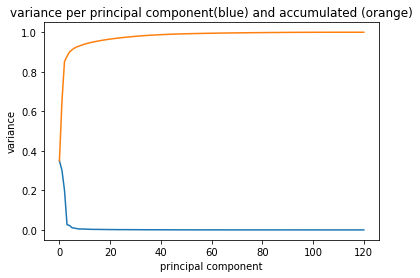

In [122]:
acc = list(pca.explained_variance_ratio_[0:idx+1].sum() for idx in range(len(pca.explained_variance_ratio_)))
explained_variance = acc[-1]
print("Explained Variance:",explained_variance)
plt.plot(pca.explained_variance_ratio_)
plt.plot(acc)
plt.ylabel("variance")
plt.xlabel("principal component")
plt.title("variance per principal component(blue) and accumulated (orange)");

In [115]:
print(len(pca.components_), pca.components_)

121 [[-1.69939507e-02  4.40714887e-05 -4.39085906e-02 ... -6.92542074e-03
   3.67086500e-02 -2.20472405e-02]
 [ 4.68926292e-02 -8.86457903e-05  3.58101785e-02 ...  2.21598292e-04
   5.57453430e-03  9.59967213e-03]
 [-4.09992450e-03 -5.51117116e-04  1.24487409e-02 ...  5.34446525e-03
  -1.32675774e-02  6.99920140e-03]
 ...
 [-0.00000000e+00  5.41233725e-16  3.86550681e-16 ... -8.62514697e-02
  -1.56125113e-17  1.21430643e-17]
 [-0.00000000e+00  3.70363462e-16  6.36279713e-17 ...  5.35068510e-03
   1.00288701e-16 -1.47451495e-17]
 [ 0.00000000e+00  1.38777878e-16  6.79127768e-17 ...  4.27869803e-02
  -2.15105711e-16  1.73472348e-18]]


In [116]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Apply PCA to the data.
explained_variances={"n":[],"expl_var":[]}
for n in range(3,30,3):
    pca = PCA(n)
    X_pca = pca.fit(azdias_clean_no_nan)
    acc = list(pca.explained_variance_ratio_[0:idx+1].sum() for idx in range(len(pca.explained_variance_ratio_)))
    explained_variance = acc[-1]
    explained_variances["n"].append(n)
    explained_variances["expl_var"].append(explained_variance)

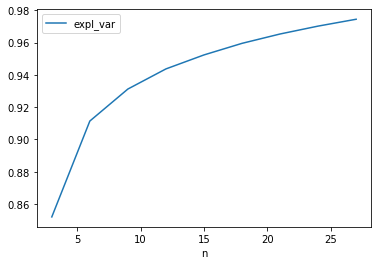

In [60]:
df_expl_var = pd.DataFrame(explained_variances)
df_expl_var.plot(x="n",y="expl_var");

Explained Variance: 0.9266707379419981


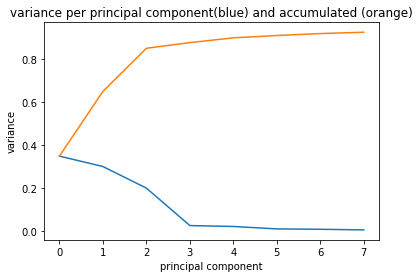

In [61]:
pca = PCA(8)
X_pca = pca.fit_transform(azdias_clean_no_nan)
acc = list(pca.explained_variance_ratio_[0:idx+1].sum() for idx in range(len(pca.explained_variance_ratio_)))
explained_variance = acc[-1]
print("Explained Variance:",explained_variance)
plt.plot(pca.explained_variance_ratio_)
plt.plot(acc)
plt.ylabel("variance")
plt.xlabel("principal component")
plt.title("variance per principal component(blue) and accumulated (orange)");

In [62]:
X_pca.shape

(687792, 8)

### Discussion 2.2: Perform Dimensionality Reduction

<span style="color:blue">
    
#### Student Note:

The dataset is already group into nine different areas. Therefore a strong reduction to 10 dimensions is not very surprising. Especially since the categorical values blow up the dataset when creating dummies. 

</span>

<!--
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
-->


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [64]:
def principal_component_details(pca, df):
    df = pd.DataFrame(pca.components_, columns=list(df.columns))
    return df

In [65]:
def get_weights_for_principal_component_details(pca, df, dig_comp_number):
    df_dig_comp = principal_component_details(pca, df)
    data = np.array(df_dig_comp.iloc[dig_comp_number].sort_values(ascending=False))    
    return data

In [66]:
principal_component_details(pca, azdias_clean_no_nan).iloc[0].sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV    0.837647
decade                 0.270062
ORTSGR_KLS9            0.049510
HH_EINKOMMEN_SCORE     0.042699
KBA05_BAUMAX           0.036930
                         ...   
KBA05_GBZ             -0.042463
FINANZ_MINIMALIST     -0.043909
MOBI_REGIO            -0.049271
LP_LEBENSPHASE_GROB   -0.121009
LP_LEBENSPHASE_FEIN   -0.421316
Name: 0, Length: 121, dtype: float64

In [67]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

principal_component_details(pca, azdias_clean_no_nan).iloc[1].sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV     0.313814
FINANZ_VORSORGER        0.070054
SEMIO_LUST              0.067133
SEMIO_ERL               0.053638
ALTERSKATEGORIE_GROB    0.046893
                          ...   
FINANZ_ANLEGER         -0.065429
SEMIO_REL              -0.068505
SEMIO_PFLICHT          -0.073189
FINANZ_SPARER          -0.076671
decade                 -0.917003
Name: 1, Length: 121, dtype: float64

In [68]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
principal_component_details(pca, azdias_clean_no_nan).iloc[2].sort_values(ascending=False)


LP_LEBENSPHASE_FEIN    0.845752
ANZ_HAUSHALTE_AKTIV    0.429932
LP_LEBENSPHASE_GROB    0.262752
decade                 0.136306
ANZ_PERSONEN           0.065059
                         ...   
KBA05_ANTG2           -0.016513
SEMIO_KRIT            -0.017680
FINANZ_HAUSBAUER      -0.020738
HH_EINKOMMEN_SCORE    -0.026728
LP_FAMILIE_GROB_1.0   -0.027557
Name: 2, Length: 121, dtype: float64

### Discussion 2.3: Interpret Principal Components
<span style="color:blue">
    
#### Student Note:
With more time available a comparison to the groups defined in the dataset could be useful. The number of active households is very high up in all 3 arrays. That means there is high correlation to this values from others. First and third have decade also very high placed. First and Second have more financial values in the top ones.

</span>

<!--
(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
-->

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

#### Due to the fact that the kmeans is taken some time the calculation is split from a rough scale to a fine one on the area of interrest

In [69]:
DO_TIME_CONSUMING_KMEANS_SCAN=True


In [70]:
X=X_pca
def run_kmeans_scan(X, start, end, step, run_number):
    results={"n":[],"score":[], "avg":[], "max":[], "min":[], "std":[], "run_number":[]}
    # Over a number of different cluster counts...
    for n_clusters in range(start,end,step):
        print("Calculate for",n_clusters)

        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        model = kmeans.fit(X)
        labels = model.labels_
        centroids = model.cluster_centers_
        results["n"].append(n_clusters)    
        #Pull out the cluster center for each model
        results["score"].append(model.score(X))

        # compute the average within-cluster distances.
        dists = euclidean_distances(model.cluster_centers_)
        avg_dist = dists.sum()/len(dists)
        #results["dists"].append(dists)
        results["avg"].append(dists.mean())
        results["max"].append(dists.max())
        results["min"].append(dists.min())
        results["std"].append(dists.std())
        results["run_number"].append(run_number)
    return results


In [71]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    run1_results = run_kmeans_scan(X, 10, 31, 5, 1)

Calculate for 10
Calculate for 15
Calculate for 20
Calculate for 25
Calculate for 30


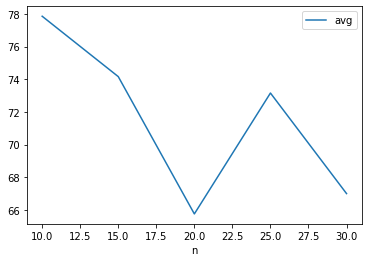

In [72]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results1 = pd.DataFrame(run1_results)
    df_kmeans_results1.plot(x="n",y="avg");

In [73]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results_combined=df_kmeans_results1
    df_kmeans_results_combined

In [74]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    run2_results = run_kmeans_scan(X, 18, 27, 2, 2)

Calculate for 18
Calculate for 20
Calculate for 22
Calculate for 24
Calculate for 26


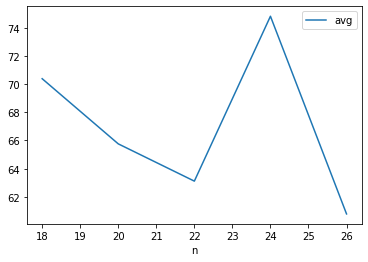

In [75]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results2 = pd.DataFrame(run2_results)
    df_kmeans_results2.plot(x="n",y="avg");


In [76]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results_combined = pd.concat([df_kmeans_results_combined,df_kmeans_results2]).sort_values("n")
    df_kmeans_results_combined

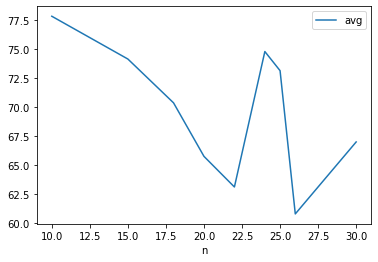

In [77]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results_combined.plot(x="n",y="avg");

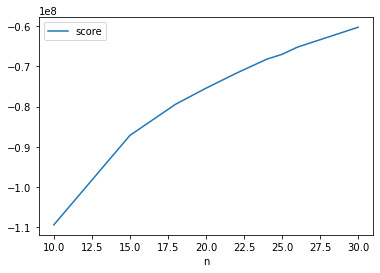

In [78]:
if DO_TIME_CONSUMING_KMEANS_SCAN:
    df_kmeans_results_combined.plot(x="n",y="score");

In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
DO_FINAL_TIME_CONSUMING_KMEANS_SCAN=True

if DO_FINAL_TIME_CONSUMING_KMEANS_SCAN:
    selected_number_of_clusters=24

    kmeans = KMeans(n_clusters=selected_number_of_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
       


In [80]:
df_temp = pd.read_html("KMeans_Table_1_2.html")
df_temp[0]

,Unnamed: 0,n,score,avg,max,min,std,run_number
0,0,10,-146965900.0,77.914412,260.382503,0.0,83.282895,1
1,0,13,-131519600.0,77.910372,284.142442,0.0,83.360597,2
2,1,15,-124719400.0,72.373007,285.009839,0.0,80.481039,1
3,1,15,-124719400.0,72.373007,285.009839,0.0,80.481039,2
4,2,17,-119301200.0,70.431985,291.615053,0.0,79.547539,2
5,3,19,-114268400.0,66.739366,291.002500,0.0,76.674274,2
6,2,20,-112361800.0,67.963522,305.886540,0.0,79.986260,1
7,4,21,-110599800.0,64.517681,291.408299,0.0,74.213393,2
8,3,25,-103615200.0,62.984325,306.408393,0.0,74.509294,1
9,4,30,-97551220.0,66.792316,347.624259,0.0,82.355168,1


### Discussion 3.1: Apply Clustering to General Population


<span style="color:blue">
    
#### Student Note:
I picked 20 clusters. There is a peek at 20. The average distance is higher but it is still not a too low number of clusters which may lead to a grouping of not connected items.


</span>

<!--
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
-->

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [81]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=';')
customers.shape

(191652, 85)

In [82]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers.copy())


Input: Rows: 191652, Cols: 85
For attribute AGER_TYP replace ['-1', '0'] with NaN
For attribute ALTERSKATEGORIE_GROB replace ['-1', '0', '9'] with NaN
For attribute ANREDE_KZ replace ['-1', '0'] with NaN
For attribute CJT_GESAMTTYP replace ['0'] with NaN
For attribute FINANZ_MINIMALIST replace ['-1'] with NaN
For attribute FINANZ_SPARER replace ['-1'] with NaN
For attribute FINANZ_VORSORGER replace ['-1'] with NaN
For attribute FINANZ_ANLEGER replace ['-1'] with NaN
For attribute FINANZ_UNAUFFAELLIGER replace ['-1'] with NaN
For attribute FINANZ_HAUSBAUER replace ['-1'] with NaN
For attribute FINANZTYP replace ['-1'] with NaN
For attribute GEBURTSJAHR replace ['0'] with NaN
For attribute HEALTH_TYP replace ['-1', '0'] with NaN
For attribute LP_LEBENSPHASE_FEIN replace ['0'] with NaN
For attribute LP_LEBENSPHASE_GROB replace ['0'] with NaN
For attribute LP_FAMILIE_FEIN replace ['0'] with NaN
For attribute LP_FAMILIE_GROB replace ['0'] with NaN
For attribute LP_STATUS_FEIN replace ['0'] 

In [83]:
customers_cleaned.shape

(127225, 120)

In [84]:
azdias_clean_no_nan.shape

(687792, 121)

In [85]:
customers_cleaned.isnull().values.any()

False

In [86]:
scaler = StandardScaler()
scaler.fit_transform(customers_cleaned)


array([[ 0.69164418, -0.69331537,  0.71236843, ...,  0.96944287,
        -1.13071964, -0.28547685],
       [ 0.69164418,  1.44234507,  0.71236843, ...,  0.96944287,
         0.28817258,  0.46095318],
       [ 0.69164418, -0.69331537,  0.71236843, ..., -1.0315203 ,
        -0.42127353,  0.46095318],
       ...,
       [ 0.69164418, -0.69331537,  0.71236843, ...,  0.96944287,
        -0.42127353,  0.46095318],
       [-0.78534242,  1.44234507, -2.26692417, ..., -1.0315203 ,
        -0.42127353,  0.46095318],
       [-2.26232902, -0.69331537,  0.71236843, ..., -1.0315203 ,
         0.28817258, -0.28547685]])

In [87]:
for x in customers_cleaned.columns:
    if x not in azdias_clean_no_nan.columns:
        print("In customers but not in original:",x)
for x in azdias_clean_no_nan.columns:
    if x not in customers_cleaned.columns:
        print("In original but not in customers:",x, "(Add since it may be consequence from creating dummies)")
        customers_cleaned[x]=0

In original but not in customers: GEBAEUDETYP_5.0 (Add since it may be consequence from creating dummies)


Explained Variance: 0.9266707379419981


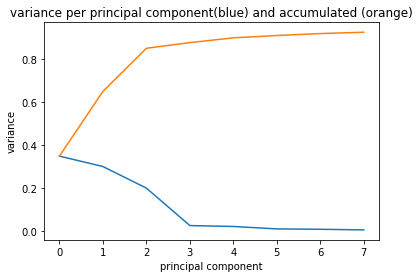

In [88]:
# using the same pca so instead of fit transform only the transform has to be executed
X_pca_c = pca.transform(customers_cleaned)

In [89]:
X_pca_c.shape

(127225, 8)

In [90]:
# now cluster the values from the pca
customer_labels = kmeans.predict(X_pca_c)


In [91]:
len(customer_labels)

127225

In [92]:
len(labels)

687792

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [93]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



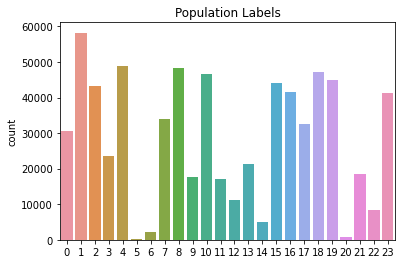

In [103]:
sns.countplot(x=labels).set(title="Population Labels");

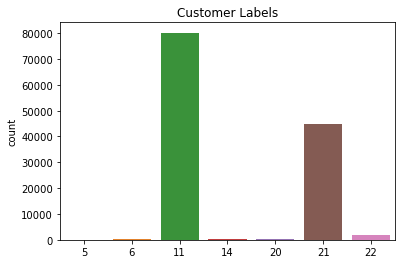

In [104]:
sns.countplot(x=customer_labels).set(title="Customer Labels");

In [111]:
df_clustered = pd.DataFrame(labels)
df_clustered.columns=["cluster_all"]
df_compare_clusters_all = df_clustered["cluster_all"].value_counts().reset_index()

df_consumer_clustered = pd.DataFrame(customer_labels)
df_consumer_clustered.columns=["cluster_customer"]
df_compare_clusters_customer = df_consumer_clustered["cluster_customer"].value_counts().reset_index() 

df_compare_clusters = pd.merge(left=df_compare_clusters_all, right=df_compare_clusters_customer, 
                               how="left", left_on="index", right_on="index")
df_compare_clusters["cluster_customer"] = df_compare_clusters["cluster_customer"].fillna(0)
df_compare_clusters.sort_values("index")


,index,cluster_all,cluster_customer
12,0,30712,0.0
0,1,58216,0.0
7,2,43268,0.0
13,3,23474,0.0
1,4,48846,0.0
23,5,197,54.0
21,6,2256,238.0
10,7,33892,0.0
2,8,48267,0.0
16,9,17744,0.0


In [98]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Focus of cluster 11


In [99]:
df_cust_clust_res = pd.DataFrame(res)
df_cust_clust_res.columns = ["cluster_number"]
df_cluster_11 = df_cust_clust_res[df_cust_clust_res["cluster_number"]==11]
df_cluster_11_merged = pd.merge(df_cluster_11, customers_cleaned, how="left", left_index=True, right_index=True)
df_cluster_11_merged

,cluster_number,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,avantgarde,household_wealth,family_status,GEBAEUDETYP_5.0
0,11,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.0,3.0,0.0
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,...,1.0,0.0,0.0,0.0,0.0,50.0,1.0,3.0,4.0,0.0
3,11,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,40.0,0.0,2.0,4.0,0.0
4,11,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,70.0,0.0,4.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127216,11,3.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,80.0,0.0,4.0,3.0,0.0
127218,11,4.0,2.0,5.0,1.0,5.0,3.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.0,0.0,2.0,3.0,0.0
127220,11,4.0,1.0,4.0,1.0,5.0,1.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,40.0,1.0,1.0,4.0,0.0
127221,11,3.0,2.0,4.0,1.0,4.0,2.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.0,0.0,2.0,4.0,0.0


In [100]:
df_cluster_11_described = df_cluster_11_merged.describe()
df_cluster_11_described.reset_index().iloc[2][2:].sort_values()


GEBAEUDETYP_5.0              0.0
GEBAEUDETYP_6.0         0.030004
GEBAEUDETYP_4.0         0.042632
ZABEOTYP_5              0.079982
LP_FAMILIE_GROB_3.0     0.098782
                         ...    
ORTSGR_KLS9             2.151566
LP_LEBENSPHASE_GROB     4.257119
LP_LEBENSPHASE_FEIN    13.079794
decade                 13.248766
ANZ_HAUSHALTE_AKTIV    13.644069
Name: 2, Length: 121, dtype: object

In [101]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# example cluster 1
df_orig_clust_res = pd.DataFrame(labels)
df_orig_clust_res.columns = ["cluster_number"]
df_cluster_1 = df_orig_clust_res[df_orig_clust_res["cluster_number"]==1]
df_cluster_1
df_cluster_1_merged = pd.merge(df_cluster_1, azdias_clean_no_nan, how="left", left_index=True, right_index=True)
df_cluster_1_merged


,cluster_number,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,avantgarde,household_wealth,family_status
25,1,1.0,1.0,3.0,5.0,3.0,5.0,4.0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,90.0,0.0,3.0,3.0
33,1,2.0,2.0,2.0,2.0,4.0,1.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,70.0,0.0,4.0,1.0
57,1,1.0,2.0,1.0,5.0,3.0,5.0,3.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,90.0,0.0,4.0,1.0
74,1,3.0,1.0,3.0,3.0,4.0,1.0,2.0,3.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,80.0,1.0,4.0,1.0
89,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687752,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687753,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687761,1,1.0,2.0,3.0,2.0,4.0,2.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,4.0
687766,1,4.0,1.0,3.0,1.0,5.0,2.0,1.0,5.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,2.0,4.0


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.